### Time Series Forecasting using LSTM and GRU
In this notebook will use LSTM & GRU for predicting the price of stocks of Google for the year 2017

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error


## Helper Functions for Plotting Predictions and Calculating RMSE

In [18]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted google Stock Price')
    plt.title('google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('google Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Getting the data

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Slpitting dataset to train set (Before 2017) and test set (2017 and beyond)

In [5]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

Visualizing the data

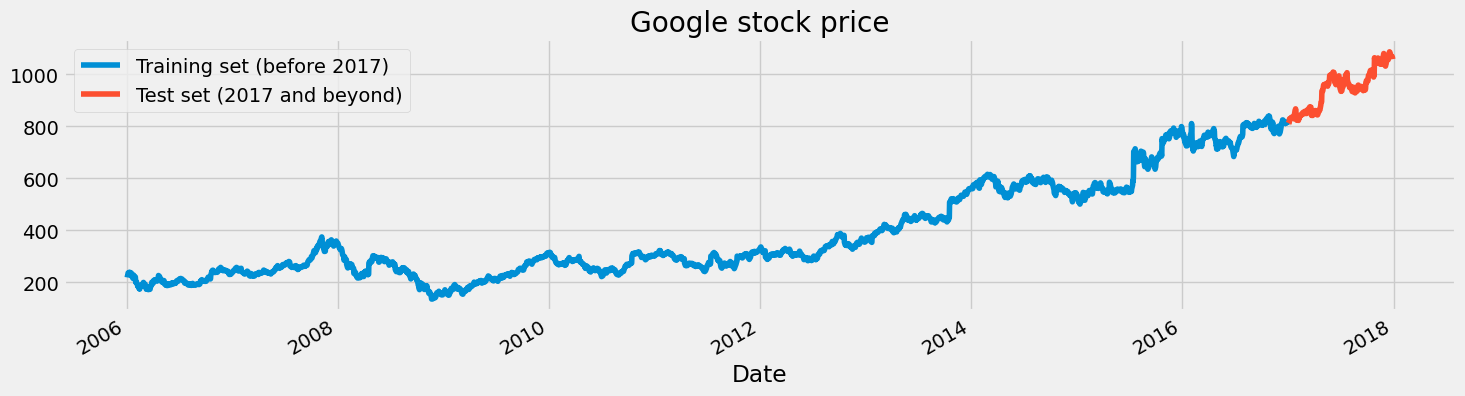

In [13]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (before 2017)','Test set (2017 and beyond)'])
plt.title('Google stock price')
plt.show()

## Data Preprocessing

Scaling the training set

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [8]:
X_train = []
y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping X_train for efficient modelling

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

## LSTM Model

In [11]:
regressor = Sequential()

#first LSTM layer
regressor.add(LSTM(units=50, return_sequences =True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

regressor.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
85/85 [==============================] - 11s 50ms/step - loss: 0.0065
Epoch 2/10
85/85 [==============================] - 4s 50ms/step - loss: 0.0034
Epoch 3/10
85/85 [==============================] - 6s 72ms/step - loss: 0.0029
Epoch 4/10
85/85 [==============================] - 4s 50ms/step - loss: 0.0026
Epoch 5/10
85/85 [==============================] - 4s 50ms/step - loss: 0.0026
Epoch 6/10
85/85 [==============================] - 6s 70ms/step - loss: 0.0023
Epoch 7/10
85/85 [==============================] - 4s 52ms/step - loss: 0.0021
Epoch 8/10
85/85 [==============================] - 4s 49ms/step - loss: 0.0022
Epoch 9/10
85/85 [==============================] - 6s 66ms/step - loss: 0.0019
Epoch 10/10
85/85 [==============================] - 5s 56ms/step - loss: 0.0018



## Make preductuion with LSTM model

In [12]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set)- 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [14]:
X_test = []
for i in range(60,inputs.shape[0]):
  X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 23ms/step


Visualizing the results

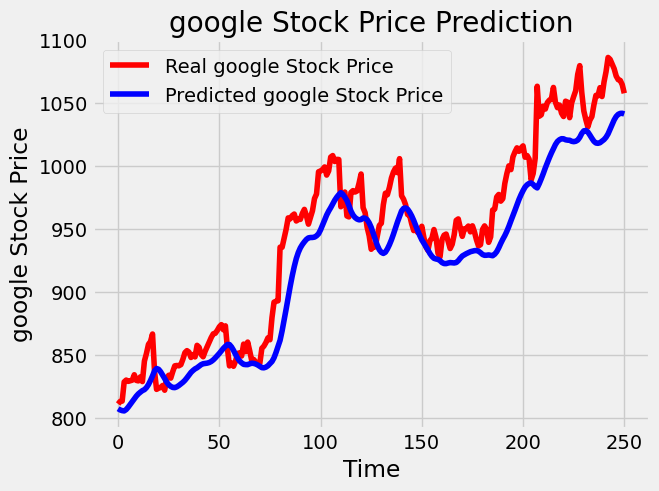

In [19]:
plot_predictions(test_set,predicted_stock_price)

Evaluating LSMT Model

In [20]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 28.854291606782834.


## GRU Model

In [22]:
from tensorflow.keras.optimizers.legacy import SGD
regressorGRU = Sequential()

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(Dense(units=1))

regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

regressorGRU.fit(X_train,y_train,epochs=10,batch_size=150)

Epoch 1/10
19/19 [==============================] - 13s 232ms/step - loss: 0.0688
Epoch 2/10
19/19 [==============================] - 4s 211ms/step - loss: 0.0164
Epoch 3/10
19/19 [==============================] - 5s 263ms/step - loss: 0.0041
Epoch 4/10
19/19 [==============================] - 5s 257ms/step - loss: 0.0034
Epoch 5/10
19/19 [==============================] - 4s 204ms/step - loss: 0.0031
Epoch 6/10
19/19 [==============================] - 4s 221ms/step - loss: 0.0028
Epoch 7/10
19/19 [==============================] - 6s 305ms/step - loss: 0.0024
Epoch 8/10
19/19 [==============================] - 4s 207ms/step - loss: 0.0023
Epoch 9/10
19/19 [==============================] - 4s 208ms/step - loss: 0.0024
Epoch 10/10
19/19 [==============================] - 6s 322ms/step - loss: 0.0024



## Make preductuion with GRU model

In [23]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 3s 43ms/step


Visualizing the Results

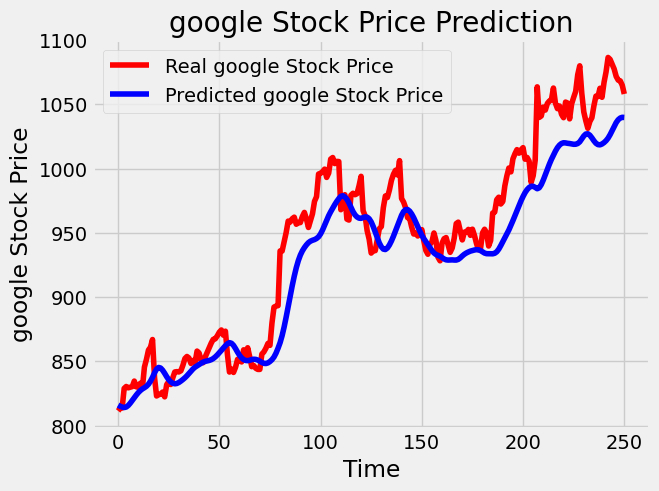

In [24]:
plot_predictions(test_set,GRU_predicted_stock_price)

Evaluating GRU Model

In [25]:

return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 28.498723292108412.
